# 3D CNN

Basic.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

# RANDOM_SEED = 421949639000
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201217-205122
Wall time: 6.05 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_deep'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'dropout': 0.10,
    'dropout': 0.70,
    'l2_beta': 0.0001,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 100,
    'patience': 25,
    'tensorboard_update_freq': 'epoch', 
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_categorical_accuracy', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_categorical_accuracy', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.015),
        'shear': (0, 2.5), # probability, degrees
        'blur': (0.2, 0.8),
        'noise': (0.2, 0.00025)
    },
    'batch_size': 10,
#     'dataset_key': '3d_deep',
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 52, 64, 52, 16)    2016      
_________________________________________________________________
batch_normalization (BatchNo (None, 52, 64, 52, 16)    64        
_________________________________________________________________
activation (Activation)      (None, 52, 64, 52, 16)    0         
_________________________________________________________________
basic_block (BasicBlock)     (None, 52, 64, 52, 16)    13984     
_________________________________________________________________
basic_block_1 (BasicBlock)   (None, 52, 64, 52, 16)    13984     
_________________________________________________________________
basic_block_2 (BasicBlock)   (None, 26, 32, 26, 16)    14256     
_________________________________________________________________
basic_block_3 (BasicBlock)   (None, 26, 32, 26, 32)    4

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201217-205122
checkpoint dir: ../../tmp\checkpoints\20201217-205122
log dir: ../../tmp\logs\20201217-205122
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 1.0748 - recall: 0.4726 - precision: 0.4726 - auc: 0.4549 - categorical_accuracy: 0.4726
Epoch 00001: val_categorical_accuracy improved from -inf to 0.38000, saving model to ../../tmp\checkpoints\20201217-205122\cp-0001.ckpt
41/41 [==============================] - 22s 543ms/step - loss: 1.0748 - recall: 0.4726 - precision: 0.4726 - auc: 0.4549 - categorical_accuracy: 0.4726 - val_loss: 0.9183 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.4548 - val_categorical_accuracy: 0.3800
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.9834 - recall: 0.4776 - precision: 0.4776 - auc: 0.4801 - categorical_accuracy: 0.4776
Epoch

Epoch 16/100
41/41 [==============================] - ETA: 0s - loss: 0.4638 - recall: 0.9030 - precision: 0.9030 - auc: 0.9626 - categorical_accuracy: 0.9030
Epoch 00016: val_categorical_accuracy did not improve from 0.64000
41/41 [==============================] - 20s 492ms/step - loss: 0.4638 - recall: 0.9030 - precision: 0.9030 - auc: 0.9626 - categorical_accuracy: 0.9030 - val_loss: 2.0330 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.4998 - val_categorical_accuracy: 0.3800
Epoch 17/100
41/41 [==============================] - ETA: 0s - loss: 0.4200 - recall: 0.9154 - precision: 0.9154 - auc: 0.9727 - categorical_accuracy: 0.9154
Epoch 00017: val_categorical_accuracy did not improve from 0.64000
41/41 [==============================] - 20s 495ms/step - loss: 0.4200 - recall: 0.9154 - precision: 0.9154 - auc: 0.9727 - categorical_accuracy: 0.9154 - val_loss: 1.5980 - val_recall: 0.5500 - val_precision: 0.5500 - val_auc: 0.5288 - val_categorical_accuracy: 0.5500
Epoch 18

41/41 [==============================] - ETA: 0s - loss: 0.2316 - recall: 0.9950 - precision: 0.9950 - auc: 1.0000 - categorical_accuracy: 0.9950
Epoch 00032: val_categorical_accuracy did not improve from 0.73000
41/41 [==============================] - 20s 494ms/step - loss: 0.2316 - recall: 0.9950 - precision: 0.9950 - auc: 1.0000 - categorical_accuracy: 0.9950 - val_loss: 1.2096 - val_recall: 0.6800 - val_precision: 0.6800 - val_auc: 0.7023 - val_categorical_accuracy: 0.6800
Epoch 33/100
41/41 [==============================] - ETA: 0s - loss: 0.2292 - recall: 0.9975 - precision: 0.9975 - auc: 1.0000 - categorical_accuracy: 0.9975
Epoch 00033: val_categorical_accuracy did not improve from 0.73000
41/41 [==============================] - 20s 498ms/step - loss: 0.2292 - recall: 0.9975 - precision: 0.9975 - auc: 1.0000 - categorical_accuracy: 0.9975 - val_loss: 1.2281 - val_recall: 0.6900 - val_precision: 0.6900 - val_auc: 0.7175 - val_categorical_accuracy: 0.6900
Epoch 34/100
41/41 [=

Epoch 49/100
41/41 [==============================] - ETA: 0s - loss: 0.2236 - recall: 0.9975 - precision: 0.9975 - auc: 0.9999 - categorical_accuracy: 0.9975
Epoch 00049: val_categorical_accuracy did not improve from 0.74000
41/41 [==============================] - 20s 499ms/step - loss: 0.2236 - recall: 0.9975 - precision: 0.9975 - auc: 0.9999 - categorical_accuracy: 0.9975 - val_loss: 1.3084 - val_recall: 0.6800 - val_precision: 0.6800 - val_auc: 0.7278 - val_categorical_accuracy: 0.6800
Epoch 50/100
41/41 [==============================] - ETA: 0s - loss: 0.2195 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 - categorical_accuracy: 1.0000
Epoch 00050: val_categorical_accuracy did not improve from 0.74000
41/41 [==============================] - 21s 502ms/step - loss: 0.2195 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 - categorical_accuracy: 1.0000 - val_loss: 1.2751 - val_recall: 0.6600 - val_precision: 0.6600 - val_auc: 0.7079 - val_categorical_accuracy: 0.6600
Epoch 51

## Evaluation

Wall time: 133 ms


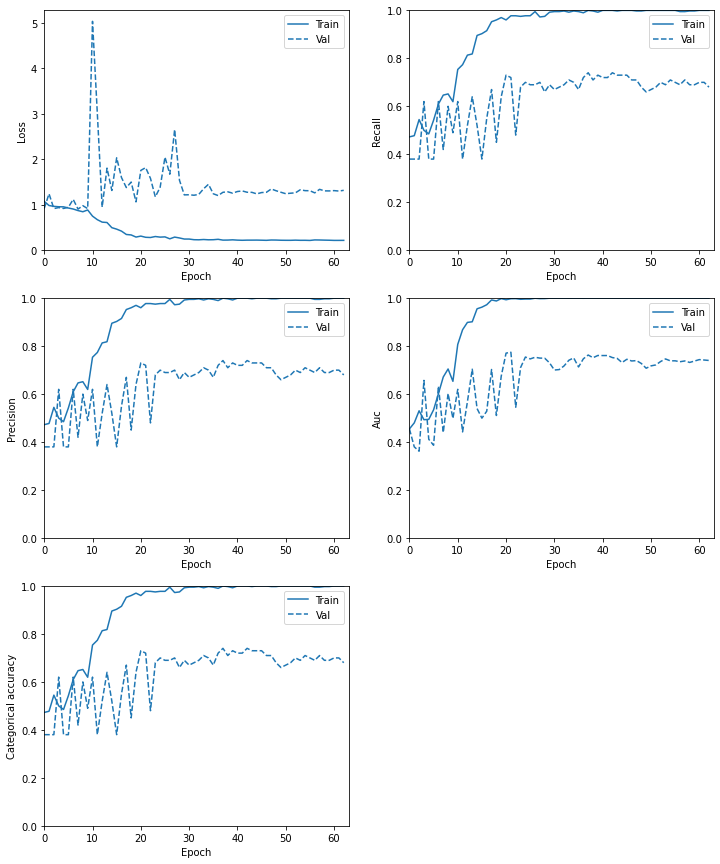

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 1.177996039390564
recall: 0.7400000095367432
precision: 0.7400000095367432
auc: 0.7630000114440918
categorical_accuracy: 0.7400000095367432

Wall time: 27.9 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8
recall: 0.7741935483870968
f1-score: 0.7868852459016393
support: 62


CN
precision: 0.65
recall: 0.6842105263157895
f1-score: 0.6666666666666667
support: 38


micro avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


macro avg
precision: 0.7250000000000001
recall: 0.7292020373514432
f1-score: 0.726775956284153
support: 100


weighted avg
precision: 0.743
recall: 0.74
f1-score: 0.7412021857923498
support: 100


samples avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


F1
micro: 0.74
macro: 0.726775956284153


accuracy_score: 0.74
sensitivity_score: 0.7741935483870968
specificity_score: 0.6842105263157895


Wall time: 22.8 s


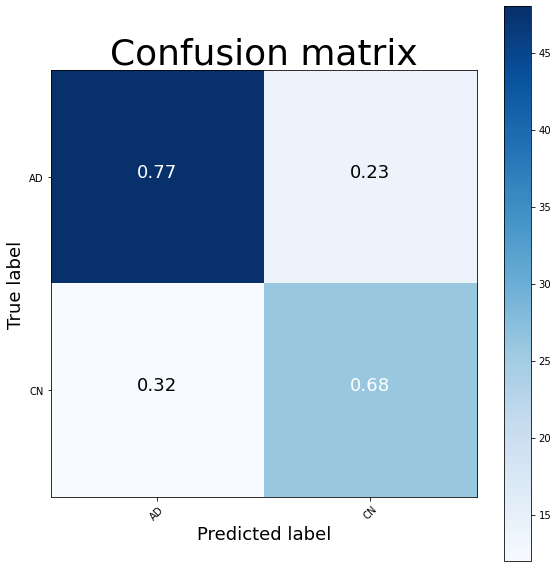

In [11]:
%%time

show_metrics(model, test_seq, class_names)